# ECON526: Quantitative Economics with Data Science Applications

Regression Analysis

Phil Solimine (University of British Columbia)

# Overview

## Summary

-   Previously we have discussed estimating treatment effects using the
    difference in means.

-   In this lecture we will discuss how to estimate treatment effects
    using regression.

-   I assume that you are familiar with the basics of linear regression,
    including the assumptions underlying OLS and the interpretation of
    regression coefficients.

# Linear Regression

## Review of Linear Regression

-   Simple linear regression is a statistical method that allows us to
    model the relationship between two variables: a dependent variable
    and an independent variable.

-   The goal of simple linear regression is to find the line of best fit
    that describes the relationship between the two variables.

-   The line of best fit is defined as the line that minimizes the sum
    of the squared differences between the observed values and the
    predicted values.

-   Mathematically, the linear regression equation is the *least-norm*
    solution to an overdetermined system of linear equations.

    -   $y = X\beta + \epsilon \longrightarrow \epsilon = y - X\beta$
    -   $\min_{\beta} ||\epsilon||_2^2 = \min_\beta \epsilon'\epsilon = \min_{\beta} (y - X\beta)'(y - X\beta)$
    -   $\hat{\beta} = \arg \min_{\beta} (y - X\beta)'(y - X\beta) = (X'X)^{-1}X'y$

## Review of Linear Regression

-   Aside: Computational complexity of OLS

-   We could solve for the OLS coefficient in a number of ways. However,
    some ways will be substantially faster than others.

In [2]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import timeit
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [3]:
from scipy.optimize import minimize
import statsmodels.api as sm
import timeit

# Generate data
np.random.seed(123)
n = 10000
X = np.random.normal(size=(n, 10))
y = np.random.normal(size=n)

# Define some different OLS functions

# Most naive way - never do this!
def ols_lstsq(X, y):
    return minimize(lambda beta: np.linalg.norm(X @ beta - y)**2, np.zeros(X.shape[1])).x

# Using the closed-form solution directly
def ols_inv(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

# Using the closed-form solution as a linear system
def ols_solve(X, y):
    return np.linalg.solve(X.T @ X, X.T @ y)

print("Time to compute OLS coefficients numerically:")
%timeit beta_min = ols_lstsq(X, y)

print("\nTime to compute OLS coefficients with a matrix inverse:")
%timeit beta_inv = ols_inv(X, y)

print("\nTime to compute OLS coefficients by solving a linear system:")
%timeit beta_solve = ols_solve(X, y)

Time to compute OLS coefficients numerically:
12.2 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Time to compute OLS coefficients with a matrix inverse:
220 µs ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Time to compute OLS coefficients by solving a linear system:
116 µs ± 2.13 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

## Review of Linear Regression

-   Aside: Computational complexity of OLS

-   Solving a matrix inverse involves computing the inverse of a matrix,
    which is a computationally expensive operation.

    -   The most common way to find the inverse of a matrix is to solve
        $n$ linear systems, where $n$ is the number of columns in the
        matrix.
    -   Each linear system is of the form $(X'X) \beta = e_i$, where $X$
        is a matrix and $e_i$ is a vector of zeros with a 1 in the
        $i_{\text{th}}$ position.
    -   Solved this way, it would take $O(n^3)$ operations to find the
        full inverse.
    -   The fastest known way to take a matrix inverse is
        ~$O(n^{2.375})$.

-   On the other hand, we don’t need to know the full inverse of
    $(X'X)$. We only need to know the solution to the linear system
    $(X'X) \beta = X'y$.

    -   This can be solved in just one set of $O(n^2)$ operations.

## Review of Linear Regression

-   In this course, we will use the `statsmodels` package to estimate
    linear regression models.
    -   It may not be the fastest, but it gets us a whole lot more
        information.

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

sm_results = sm.OLS(y, X).fit()
print(sm_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              1.198
Date:                Sun, 29 Oct 2023   Prob (F-statistic):                       0.286
Time:                        23:51:57   Log-Likelihood:                         -14130.
No. Observations:               10000   AIC:                                  2.828e+04
Df Residuals:                    9990   BIC:                                  2.835e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Treatment Effects

## Treatment Effects

-   When estimating “treatment effects” with linear regression, we run
    into exactly the same problem as when we estimate using the
    difference in means.
    -   $Y_i = Y_{0i}(1-T_i) + Y_{1i}T_i$
    -   If we don’t know both potential outcomes, we can’t estimate the
        treatment effect.
-   However, we can estimate the treatment effect if we make some
    assumptions about the data generating process.
    -   The best case scenario is that we have an RCT.
    -   Otherwise, we have to make sure that we close off all other
        channels through which the treatment could affect the outcome.

## Treatment Effects

-   For starters, let’s assume that we have an RCT.

-   We’ll compute the treatment effect both using the difference in
    means we used before, and also using regression.

In [5]:
df = pd.read_csv("data/online_classroom.csv")
df_no_blended = df[df["format_blended"] == 0]

# Difference in means
te = df_no_blended.groupby("format_ol")["falsexam"].mean().diff()
print(f"Estimated treatment effect: {te[1]:.3f}\n")

# Regression
sm_results = smf.ols("falsexam ~ format_ol", data=df_no_blended).fit()
print(sm_results.summary().tables[1])

Estimated treatment effect: -4.912

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     78.5475      1.113     70.563      0.000      76.353      80.742
format_ol     -4.9122      1.680     -2.925      0.004      -8.223      -1.601

## Treatment Effects

-   Because we just have a binary treatment, the difference in means and
    the regression coefficient are the same.
    -   $E[Y_i\mid T_i] = \beta_0 + \beta_1 T_i + \epsilon_i$
    -   $\bar\tau = E[Y_i\mid T_i=1] - E[Y_i\mid T_i=0] = (\beta_0 + \beta_1*1)-(\beta_0 + \beta_1 * 0) = \beta_1$
-   With only one (binary) variable, it may not be clear why we
    (usually) prefer regression over the difference in means.
    -   However, regression makes it much easier to control for other
        variables.

## Treatment Effects

-   For example, suppose we want to control for the student’s gender.
    -   In this example, gender is not a confounder because we have an
        RCT.
    -   However, we can still control for it in the regression, and it
        should improve the precision of our estimate.
-   To “control for” a covariate using the difference in means, we have
    to create subsamples of the data that have no variation in that
    variable
    -   In other words, we look at *conditional* differences in means.
-   With regression, controlling for a variable is as simple as
    including it on the right hand side.

# Regression with Nonlinearities

## Regression with Nonlinearities

-   What if we don’t think that there is a linear relationship between
    the treatment and the outcome?

-   We can still use linear regression, but we need to be careful about
    how we interpret the coefficients.

-   For example, if we think that the treatment effect is nonlinear, we
    can include a quadratic term for the treatment.

    -   $Y_i = \beta_0 + \beta_1 T_i + \beta_2 T_i^2 + \epsilon_i$
    -   This works simply by creating a new column in the data that is
        the square of the treatment variable.

## Regression with Nonlinearities

-   We can also include other nonlinear transformations of the treatment
    variable.
    -   $Y_i = \beta_0 + \beta_1 T_i + \beta_2 \log(T_i) + \epsilon_i$
    -   $Y_i = \beta_0 + \beta_1 T_i + \beta_2 T_i^2 + \beta_3 \log(T_i) + \epsilon_i$
    -   $Y_i = \beta_0 + \beta_1 T_i + \beta_2 T_i^2 + \beta_3 \log(T_i) + \beta_4 \log(T_i)^2 + \epsilon_i$
-   But we should be careful doing stuff like this. It’s easy to overfit
    the data.
    -   In fact, if we have $k$ data points and specify a $k-1$-th order
        polynomial, we can always fit the data perfectly.

## Regression with Nonlinearities

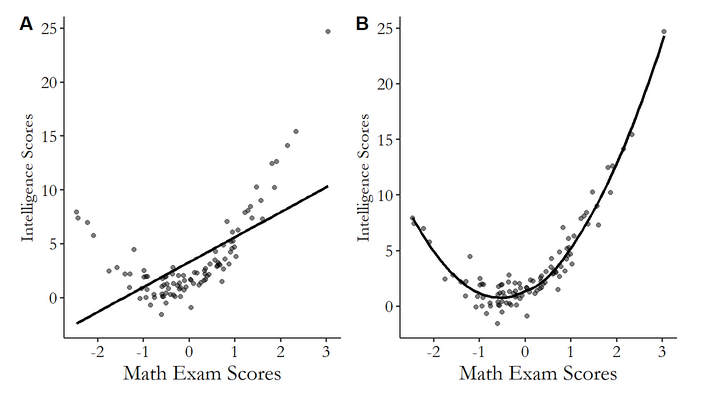

## Regression with Nonlinearities

-   We could also transform the dependent variable, rather than the
    treatment variable.
-   For example, let’s imagine we wanted to estimate a Cobb-Douglas
    function.
    -   $Y = z K^\alpha L^\beta$ where $z$ is productivity, $K$ is
        capital, and $L$ is labor.
    -   This equation is nonlinear in the parameters $\alpha$ and
        $\beta$.
    -   However, we can transform it to be linear using the log.
    -   $\ln Y = \ln z + \alpha \ln K + \beta \ln L$
-   This trick works whenever the dependent variable is an invertible
    function of an equation that is linear in parameters.
    -   $Y = f(\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_k X_k)$
    -   $f^{-1}(Y) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_k X_k$

## Limited Dependent Variables

-   Sometimes the dependent variable is not continuous.
    -   For example, it might be binary (did the student pass the exam?)
    -   Or it might be a count (how many times did the student log in
        canvas?)
-   In these cases, we shouldn’t just apply OLS blindly
    -   Often we can work around this by transforming the dependent
        variable.
    -   For example, we can use a logistic regression to estimate the
        *probability* of passing the exam.
-   Let $F(x) = \frac{e^x}{1+e^x}$ be the logistic function and
    -   $P(Y_i = 1) = F(\beta_0 + \beta_1 X_{1i} + \beta_2 X_{2i} + \dots + \beta_k X_{ki})$
    -   $Y_i \sim \text{Bernoulli}(P(Y_i = 1))$

## Limited Dependent Variables

In [6]:
from causaldata import restaurant_inspections
df = restaurant_inspections.load_pandas().data

df.head()

## Limited Dependent Variables

In [7]:
# Statsmodels wants the dependent variable to be numeric
df["Weekend"] = 1*df["Weekend"]

# How is the frequency of weekend inspections changing over time?
m1 = smf.logit(formula = "Weekend ~ Year", data = df).fit()

print(m1.summary().tables[1])

Optimization terminated successfully.
         Current function value: 0.045192
         Iterations 10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     44.2360     23.502      1.882      0.060      -1.828      90.300
Year          -0.0244      0.012     -2.088      0.037      -0.047      -0.002

## Limited Dependent Variables

-   The coefficient on `Year` is negative, which indicates that the
    frequency of weekend inspections is decreasing over time.
-   Notice that we have a new message: “Optimization terminated
    successfully”
    -   Since this GLM is nonlinear, we can’t use the formula for OLS

## Limited Dependent Variables

-   In order to actually interpret this coefficient, we prefer to know
    the **marginal effect** of `Year` rather than the coefficient value
    itself.

In [8]:
# Compute the marginal effect of Year
print(m1.get_margeff(at="mean").summary())

        Logit Marginal Effects       
Dep. Variable:                Weekend
Method:                          dydx
At:                              mean
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Year          -0.0002   8.79e-05     -2.110      0.035      -0.000   -1.32e-05

# Interactions

## Interactions

-   What if the treatment effect itself is heterogeneous?

    -   For example, maybe the treatment effect is larger for students
        who are more engaged in the class.

-   When comparing means, we would have to create subsamples of the data
    and estimate the treatment effect separately for each subsample.

-   In a regression equation, we can incorporate heterogeneous treatment
    effects using **interaction terms**.

    -   $Y_i = \beta_0 + \beta_1 T_i + \beta_2 X_i + \beta_3 T_i X_i + \epsilon_i$
    -   $E[Y_i\mid T_i, X_i] = \beta_0 + \beta_1 T_i + \beta_2 X_i + \beta_3 T_i X_i$

## Interactions

In [9]:
# Use * to include two variables independently
# plus their interaction
# (: is interaction-only, we rarely use it)
m1 = smf.ols(formula = "inspection_score ~ NumberofLocations*Weekend + Year", data = df).fit()

print(m1.summary().tables[1])
m1.t_test("NumberofLocations + NumberofLocations:Weekend = 0")

                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   225.1260     12.415     18.134      0.000     200.793     249.460
NumberofLocations            -0.0191      0.000    -43.759      0.000      -0.020      -0.018
Weekend                       1.7592      0.488      3.606      0.000       0.803       2.715
NumberofLocations:Weekend    -0.0098      0.008     -1.307      0.191      -0.025       0.005
Year                         -0.0648      0.006    -10.494      0.000      -0.077      -0.053

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0289      0.008     -3.851      0.000      -0.044      -0.014

## Interactions

-   In this example, it looks like the effect of the number of locations
    on the inspection score is strengthened on the weekend.

    -   (Assuming we have some causal model to justify that this is
        unbiased)

-   Interactions are easiest to interpret when they are categorical;
    each group has their own treatment effect.

-   However, they also work with continuous variables.

    -   In this case, the treatment effect is a function of the other
        variable.
    -   We could say that a certain variable “moderates” the treatment
        effect.

## Interactions

-   Why not just make everything interact with everything else?
    -   We could, but it would be hard to interpret the coefficients.
    -   It would also be easy to overfit the data.
    -   In order to identify the interaction terms, we want lots of
        variation across both variables.
-   Interactions are most useful when we have a *theory* about how the
    treatment effect varies with other variables.
    -   For example, we might think that the treatment effect of online
        class is larger for students who are more engaged in the class,
        or vice versa
-   Generally, it’s good to include interactions if they are a primary
    focus of the analysis.

# Translating Causal Diagrams to Regression

## Translating Causal Diagrams to Regression

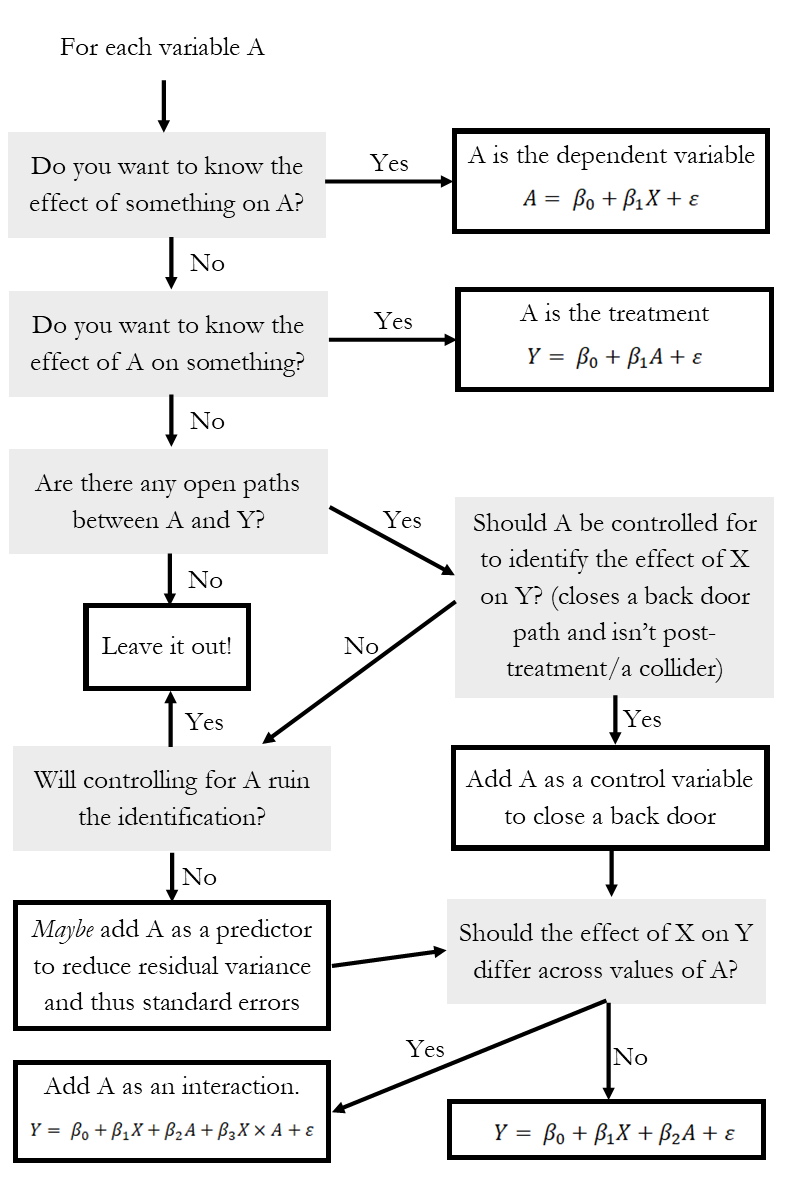

## Credits

This lecture draws heavily from [Causal Inference for the Brave and
True: Chapter 05 - The Unreasonable Effectiveness of Linear
Regression](https://matheusfacure.github.io/python-causality-handbook/05-The-Unreasonable-Effectiveness-of-Linear-Regression.html)
and [Chapter 06 - Grouped and Dummy
Regression](https://matheusfacure.github.io/python-causality-handbook/06-Grouped-and-Dummy-Regression.html)
by Matheus Facure.

As well as [The Effect: Chapter 13 -
Regression](https://www.theeffectbook.net/ch-StatisticalAdjustment.html)
by Nick Huntington-Klein.